In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import joblib
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_path = r'D:\FINAL YEAR PROJECT\FULL CODE\DATA.csv'
data = pd.read_csv(file_path)

In [43]:
data.head()

,Transaction ID,Timestamp,Sender UPI ID,Receiver UPI ID,Amount (INR),Status,Transaction Speed (min),User Transaction Frequency,Account Age (days),Fraud Label
0,b5749457-ca68-4346-a033-1fbebe4b3bdc,19-10-2023 17:12,4696217142@okaxis,5089047536@oksbi,22033.01,SUCCESS,1.400200,9,2849,1
1,f34e1912-7608-4caa-9b74-0ba482a740dc,02-05-2023 23:04,8006150754@okicici,6171444010@oksbi,33364.78,SUCCESS,20.284287,29,68,0
2,274b7789-d565-4101-97fb-9a25388f8362,18-05-2023 03:17,2965512251@okhdfcbank,2185048499@okaxis,29383.77,SUCCESS,5.252411,8,1860,0
3,3a2bbd55-0797-4555-9b85-92b3bb3093c0,20-09-2023 09:35,4628476194@oksbi,7696068832@okybl,29165.32,SUCCESS,9.902797,91,665,0
4,d4586ddc-478b-4ef0-9c1a-410a13935b19,13-06-2023 11:12,9401099675@okaxis,2899739841@oksbi,6666.34,SUCCESS,1.413072,84,622,0


In [44]:
data.shape

(10000, 10)

In [45]:
data.columns

Index(['Transaction ID', 'Timestamp', 'Sender UPI ID', 'Receiver UPI ID',
       'Amount (INR)', 'Status', 'Transaction Speed (min)',
       'User Transaction Frequency', 'Account Age (days)', 'Fraud Label'],
      dtype='object')

In [46]:
data.dtypes

Transaction ID                 object
Timestamp                      object
Sender UPI ID                  object
Receiver UPI ID                object
Amount (INR)                  float64
Status                         object
Transaction Speed (min)       float64
User Transaction Frequency      int64
Account Age (days)              int64
Fraud Label                     int64
dtype: object

In [47]:
numerical_column_names = data.select_dtypes(include=['number']).columns.tolist()
print(numerical_column_names)

['Amount (INR)', 'Transaction Speed (min)', 'User Transaction Frequency', 'Account Age (days)', 'Fraud Label']


In [48]:
object_column_names = data.select_dtypes(include=['object']).columns.tolist()
print(object_column_names)

['Transaction ID', 'Timestamp', 'Sender UPI ID', 'Receiver UPI ID', 'Status']


In [49]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data.drop(columns=['Timestamp'], inplace=True)

In [50]:
data.head()

,Transaction ID,Sender UPI ID,Receiver UPI ID,Amount (INR),Status,Transaction Speed (min),User Transaction Frequency,Account Age (days),Fraud Label,Year,Month,Day
0,b5749457-ca68-4346-a033-1fbebe4b3bdc,4696217142@okaxis,5089047536@oksbi,22033.01,SUCCESS,1.400200,9,2849,1,2023,10,19
1,f34e1912-7608-4caa-9b74-0ba482a740dc,8006150754@okicici,6171444010@oksbi,33364.78,SUCCESS,20.284287,29,68,0,2023,5,2
2,274b7789-d565-4101-97fb-9a25388f8362,2965512251@okhdfcbank,2185048499@okaxis,29383.77,SUCCESS,5.252411,8,1860,0,2023,5,18
3,3a2bbd55-0797-4555-9b85-92b3bb3093c0,4628476194@oksbi,7696068832@okybl,29165.32,SUCCESS,9.902797,91,665,0,2023,9,20
4,d4586ddc-478b-4ef0-9c1a-410a13935b19,9401099675@okaxis,2899739841@oksbi,6666.34,SUCCESS,1.413072,84,622,0,2023,6,13


In [51]:
data.describe()

,Amount (INR),Transaction Speed (min),User Transaction Frequency,Account Age (days),Fraud Label,Year,Month,Day
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,24509.838729,15.012773,49.686400,1828.777200,0.500000,2023.0,6.525700,15.506400
std,14435.843495,8.477782,28.859458,1052.085514,0.500025,0.0,3.484531,8.729718
min,10.020000,0.501493,1.000000,1.000000,0.000000,2023.0,1.000000,1.000000
25%,11767.340000,7.656004,24.000000,905.000000,0.000000,2023.0,3.000000,8.000000
50%,24188.080000,14.753011,49.000000,1830.000000,0.500000,2023.0,7.000000,15.000000
75%,37126.620000,22.451471,75.000000,2713.000000,1.000000,2023.0,10.000000,23.000000
max,49999.550000,29.994586,99.000000,3649.000000,1.000000,2023.0,12.000000,31.000000


In [52]:
data.isna().sum()

Transaction ID                0
Sender UPI ID                 0
Receiver UPI ID               0
Amount (INR)                  0
Status                        0
Transaction Speed (min)       0
User Transaction Frequency    0
Account Age (days)            0
Fraud Label                   0
Year                          0
Month                         0
Day                           0
dtype: int64

In [53]:
data['Fraud Label'].value_counts()

Fraud Label
1    5000
0    5000
Name: count, dtype: int64

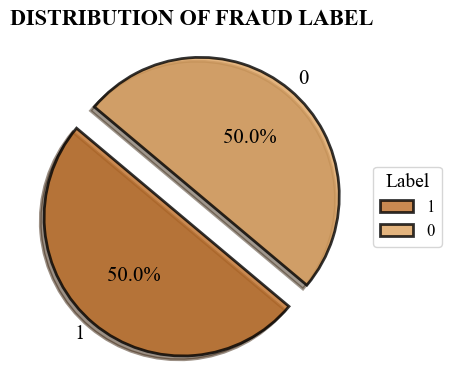

In [54]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(6, 4))
state_values = data['Fraud Label'].value_counts().index
colors = ['#bc6c25', '#dda15e']  
explode = [0.1] * len(state_values) 

data['Fraud Label'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    colors=colors[:len(state_values)],  
    explode=explode,  
    wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': 'solid', 'alpha': 0.8}, 
    shadow=True,  
    startangle=140,  
    pctdistance=0.55,  
    textprops={'fontsize': 15}  
)

plt.title('DISTRIBUTION OF FRAUD LABEL', fontsize=16, fontweight='bold', color='black')
plt.ylabel('')
plt.legend(state_values, title="Label", loc="center left", bbox_to_anchor=(1, 0.5), title_fontsize=14, fontsize=12)  

plt.tight_layout()
plt.show()


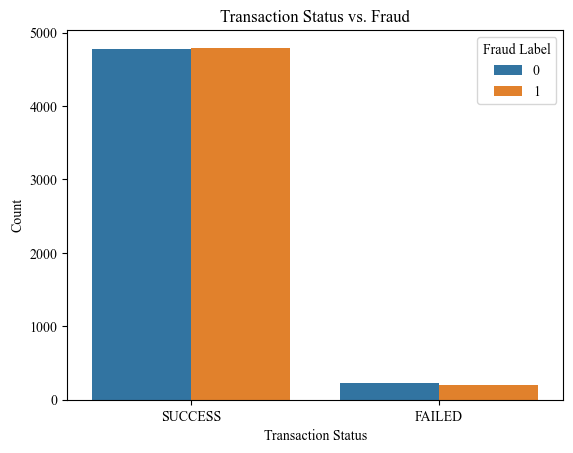

In [56]:
sns.countplot(data=data, x='Status', hue='Fraud Label')
plt.title("Transaction Status vs. Fraud")
plt.xlabel("Transaction Status")
plt.ylabel("Count")
plt.show()


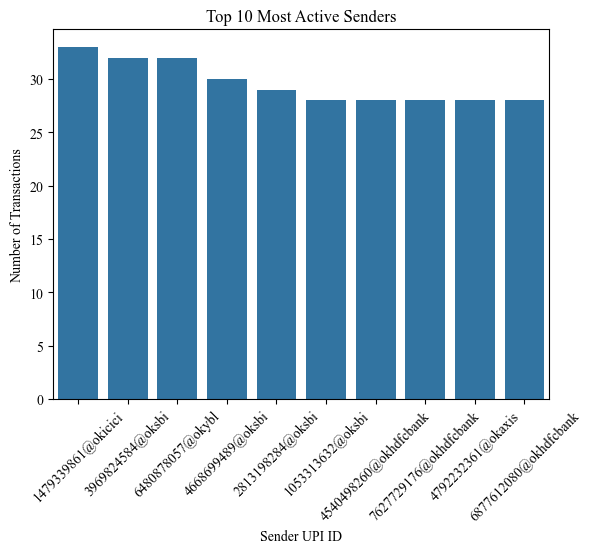

In [64]:
top_senders = data['Sender UPI ID'].value_counts().head(10)
sns.barplot(x=top_senders.index, y=top_senders.values)
plt.title("Top 10 Most Active Senders")
plt.xlabel("Sender UPI ID")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

In [65]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le


In [66]:
data.head(10)

,Transaction ID,Sender UPI ID,Receiver UPI ID,Amount (INR),Status,Transaction Speed (min),User Transaction Frequency,Account Age (days),Fraud Label,Year,Month,Day
0,4285,501,509,22033.01,1,1.400200,9,2849,1,2023,10,19
1,5690,803,610,33364.78,1,20.284287,29,68,0,2023,5,2
2,920,322,202,29383.77,1,5.252411,8,1860,0,2023,5,18
3,1361,489,769,29165.32,1,9.902797,91,665,0,2023,9,20
4,5006,940,291,6666.34,1,1.413072,84,622,0,2023,6,13
5,209,47,897,25605.95,1,2.888018,76,1550,1,2023,4,28
6,5213,798,431,48159.68,1,24.450101,16,1941,0,2023,9,4
7,5169,858,41,33142.16,1,26.338602,43,14,1,2023,2,2
8,5827,928,666,25713.34,1,13.040169,59,549,1,2023,2,1
9,3168,762,951,34532.23,1,16.601883,9,1456,0,2023,11,10


In [67]:
X = data.drop('Fraud Label', axis=1)
y = data['Fraud Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, 'scaler_fraud.pkl')  

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## RADOM FOREST MODEL

In [68]:
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy for Random forest:", accuracy_score(y_test, y_pred))

Accuracy for Random forest: 0.916


In [70]:
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      1013
           1       0.87      0.97      0.92       987

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



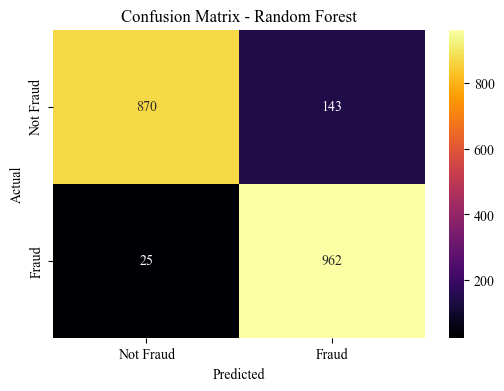

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


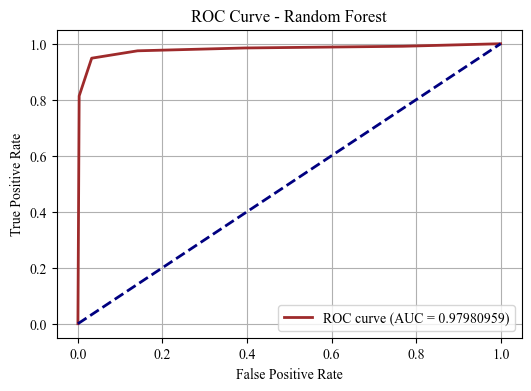

In [21]:
y_probs = rf.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='#9e2a2b', lw=2, label=f'ROC curve (AUC = {roc_auc:.8f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## XG BOOST MODEL

In [71]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:, 1]
print("Accuracy fot XGBOOST:", accuracy_score(y_test, y_pred))

Accuracy fot XGBOOST: 0.9075


In [72]:
print(" XGBOOST Classification Report:\n", classification_report(y_test, y_pred))

 XGBOOST Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      1013
           1       0.87      0.96      0.91       987

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



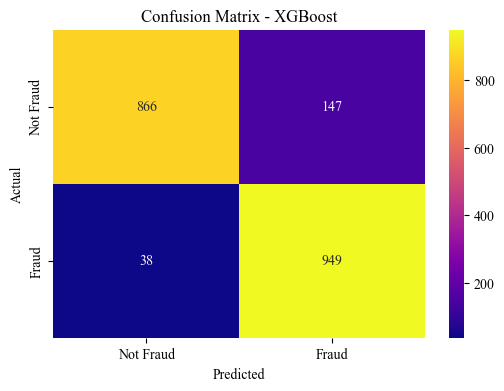

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

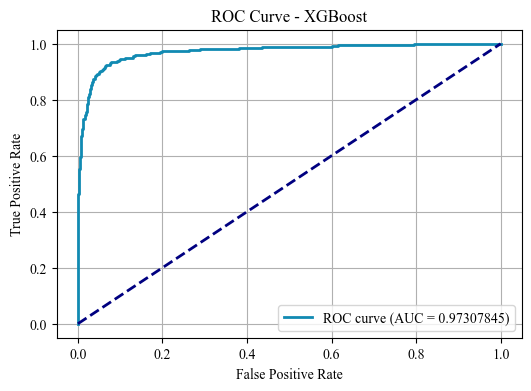

In [25]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='#118ab2', lw=2, label=f'ROC curve (AUC = {roc_auc:.8f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## LSTM MODEL

In [26]:
X_train_lstm = X_train.reshape(X_train.shape[0], 11, 1) 
X_test_lstm = X_test.reshape(X_test.shape[0], 11, 1)

In [27]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [28]:
model = Sequential()
model.add(LSTM(512, input_shape=(11, 1)))  
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(
    X_train_lstm, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_cat),
    verbose=1
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.5107 - loss: 0.6961 - val_accuracy: 0.5175 - val_loss: 0.6923
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5140 - loss: 0.6931 - val_accuracy: 0.5110 - val_loss: 0.6935
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5180 - loss: 0.6934 - val_accuracy: 0.5050 - val_loss: 0.6941
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5116 - loss: 0.6933 - val_accuracy: 0.5035 - val_loss: 0.6936
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5153 - loss: 0.6936 - val_accuracy: 0.5280 - val_loss: 0.6918
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5211 - loss: 0.6927 - val_accuracy: 0.5115 - val_loss: 0.6919
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5115 - loss: 0.6930 - val_accuracy: 0.5145 - val_loss: 0.6922
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.5131 - loss: 0.6935 - 

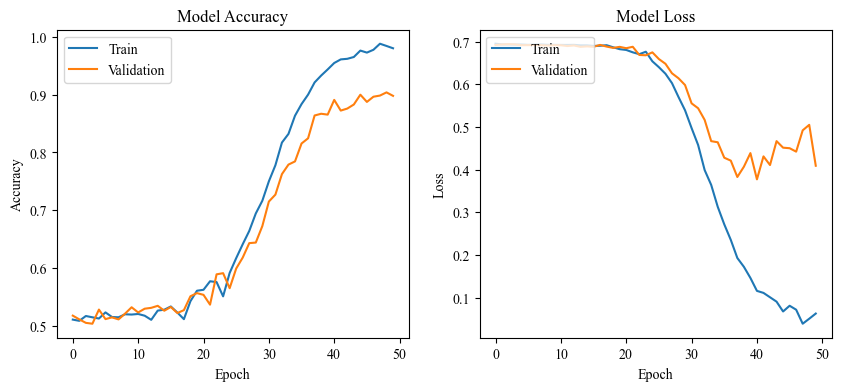

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
y_pred_prob = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
report = classification_report(y_true, y_pred)
print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1013
           1       0.85      0.96      0.90       987

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



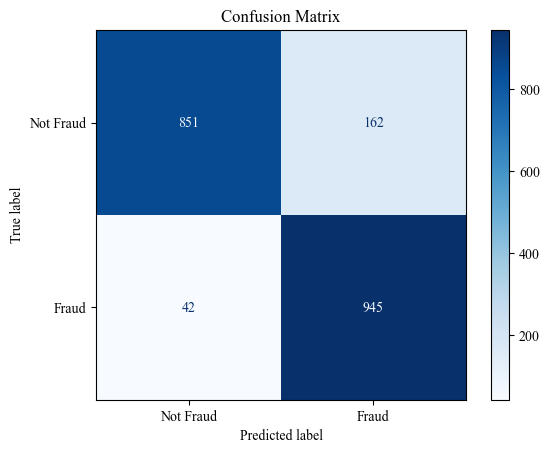

In [31]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


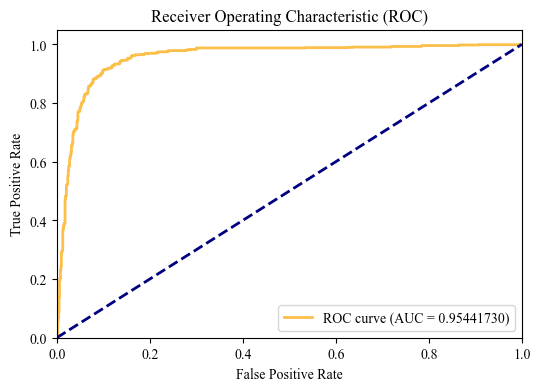

In [32]:
from sklearn.metrics import roc_curve, auc
y_pred_probs = model.predict(X_test_lstm)
y_scores = y_pred_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='#fcbf49', lw=2, label=f'ROC curve (AUC = {roc_auc:.8f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## HYBRID MODEL

In [33]:
rf_probs = rf.predict_proba(X_test)[:, 1]         
xgb_probs = xgb_model.predict_proba(X_test)[:, 1] 
lstm_probs = model.predict(X_test_lstm)[:, 1]     
avg_probs = (rf_probs + xgb_probs + lstm_probs) / 3
hybrid_preds = (avg_probs >= 0.5).astype(int)
print("Hybrid Model Accuracy:", accuracy_score(y_test, hybrid_preds))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Hybrid Model Accuracy: 0.949


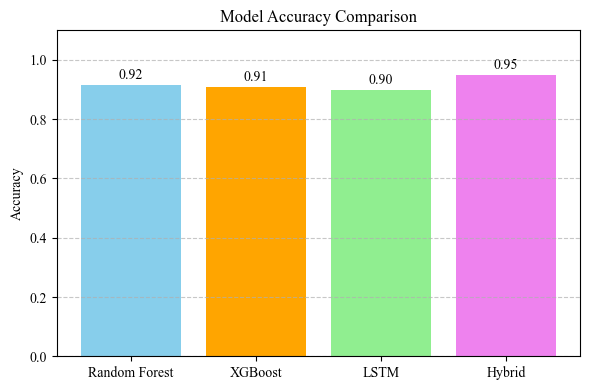

In [34]:
acc_rf = accuracy_score(y_test, rf.predict(X_test))
acc_xgb = accuracy_score(y_test, xgb_model.predict(X_test))
acc_lstm = history.history['val_accuracy'][-1]  
acc_hybrid = accuracy_score(y_test, hybrid_preds)

models = ['Random Forest', 'XGBoost', 'LSTM', 'Hybrid']
accuracies = [acc_rf, acc_xgb, acc_lstm, acc_hybrid]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange', 'lightgreen', 'violet'])

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
print("Classification Report for Hybrid Model:")
print(classification_report(y_test, hybrid_preds))

Classification Report for Hybrid Model:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1013
           1       0.93      0.98      0.95       987

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



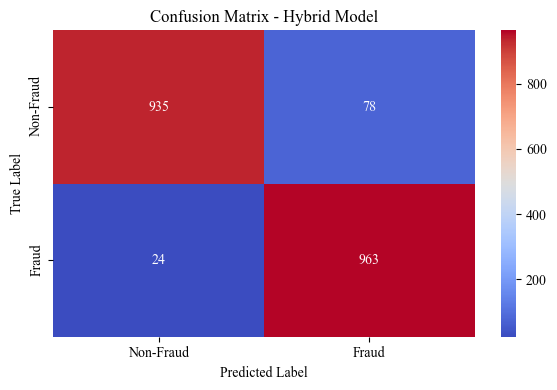

In [36]:
cm = confusion_matrix(y_test, hybrid_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Hybrid Model')
plt.tight_layout()
plt.show()

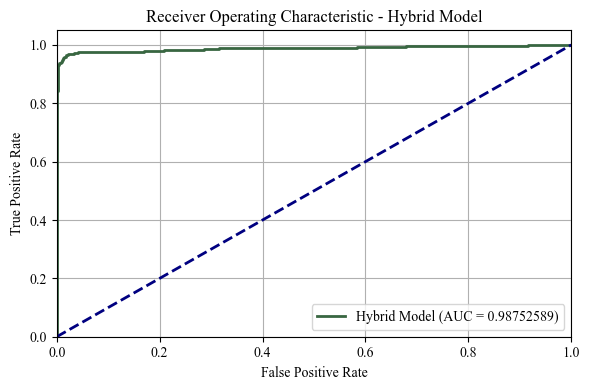

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, avg_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='#386641', lw=2, label=f'Hybrid Model (AUC = {roc_auc:.8f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Hybrid Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
import joblib
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
model.save('lstm_model.h5')

In [40]:
scaler = joblib.load('scaler_fraud.pkl')
rf_loaded = joblib.load('random_forest_model.pkl')
xgb_loaded = joblib.load('xgboost_model.pkl')
lstm_loaded = load_model('lstm_model.h5')
feature_names = joblib.load('feature_names.pkl')

new_sample = [[4285, 501, 509, 22033.01, 1, 1.400200, 9, 2849, 2023, 10, 19]]
new_data = pd.DataFrame(new_sample, columns=feature_names)

new_data_scaled = scaler.transform(new_data)
new_data_lstm = new_data_scaled.reshape(new_data_scaled.shape[0], new_data_scaled.shape[1], 1)

rf_probs = rf_loaded.predict_proba(new_data_scaled)[:, 1]
xgb_probs = xgb_loaded.predict_proba(new_data_scaled)[:, 1]
lstm_probs = lstm_loaded.predict(new_data_lstm)[:, 1]

avg_probs = (rf_probs + xgb_probs + lstm_probs) / 3
hybrid_pred = (avg_probs >= 0.5).astype(int)
if hybrid_pred[0] == 1:
    print("🚨 The transaction is predicted to be **FRAUDULENT**.")
else:
    print("✅ The transaction is predicted to be **NOT FRAUD**.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
🚨 The transaction is predicted to be **FRAUDULENT**.


In [41]:
from tensorflow.keras.models import load_model
scaler = joblib.load('scaler_fraud.pkl')
rf_loaded = joblib.load('random_forest_model.pkl')
xgb_loaded = joblib.load('xgboost_model.pkl')
lstm_loaded = load_model('lstm_model.h5')
feature_names = joblib.load('feature_names.pkl')
new_sample = [[5690,	803,	610,	33364.78,	1,	20.284287,	29,	68,	2023,	5,	2]]
new_data = pd.DataFrame(new_sample, columns=feature_names)
new_data_scaled = scaler.transform(new_data)
new_data_lstm = new_data_scaled.reshape(new_data_scaled.shape[0], new_data_scaled.shape[1], 1)
rf_probs = rf_loaded.predict_proba(new_data_scaled)[:, 1]
xgb_probs = xgb_loaded.predict_proba(new_data_scaled)[:, 1]
lstm_probs = lstm_loaded.predict(new_data_lstm)[:, 1]
avg_probs = (rf_probs + xgb_probs + lstm_probs) / 3
hybrid_pred = (avg_probs >= 0.5).astype(int)
if hybrid_pred[0] == 1:
    print("🚨 The transaction is predicted to be **FRAUDULENT**.")
else:
    print("✅ The transaction is predicted to be **NOT FRAUD**.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
✅ The transaction is predicted to be **NOT FRAUD**.


In [95]:
data.head(10)

,Transaction ID,Sender UPI ID,Receiver UPI ID,Amount (INR),Status,Transaction Speed (min),User Transaction Frequency,Account Age (days),Fraud Label,Year,Month,Day
0,4285,501,509,22033.01,1,1.400200,9,2849,1,2023,10,19
1,5690,803,610,33364.78,1,20.284287,29,68,0,2023,5,2
2,920,322,202,29383.77,1,5.252411,8,1860,0,2023,5,18
3,1361,489,769,29165.32,1,9.902797,91,665,0,2023,9,20
4,5006,940,291,6666.34,1,1.413072,84,622,0,2023,6,13
5,209,47,897,25605.95,1,2.888018,76,1550,1,2023,4,28
6,5213,798,431,48159.68,1,24.450101,16,1941,0,2023,9,4
7,5169,858,41,33142.16,1,26.338602,43,14,1,2023,2,2
8,5827,928,666,25713.34,1,13.040169,59,549,1,2023,2,1
9,3168,762,951,34532.23,1,16.601883,9,1456,0,2023,11,10
